In [1]:
import xgboost as xgb
import pandas as pd
from predict import create_features
from preprocessing import get_train_test
import shap

2022-12-12 22:14:08.594960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 22:14:08.965964: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-12 22:14:10.843013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-12 22:14:10.843720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
DATA_DIR = "./data"
df_ce = pd.read_csv('dataframes/df_champs_elysees.csv')
df_sts = pd.read_csv('dataframes/df_saints_peres.csv')
df_conv = pd.read_csv('dataframes/df_saints_peres.csv')

df_ce['Date'] = pd.to_datetime(df_ce['Date'])
df_sts['Date'] = pd.to_datetime(df_sts['Date'])
df_conv['Date'] = pd.to_datetime(df_conv['Date'])

df_ce['Date et heure de comptage'] = pd.to_datetime(df_ce['Date et heure de comptage'])
df_sts['Date et heure de comptage'] = pd.to_datetime(df_sts['Date et heure de comptage'])
df_conv['Date et heure de comptage'] = pd.to_datetime(df_conv['Date et heure de comptage'])

In [3]:
df_train_ce, df_test_ce = get_train_test(df_ce)
df_train_sts, df_test_sts = get_train_test(df_sts)
df_train_conv, df_test_conv = get_train_test(df_conv)

## Predictions pour le débit horaire

In [4]:
X_train_sts,y_train_sts = create_features(df_train_sts,label="Débit horaire")
X_test_sts, y_test_sts = create_features(df_test_sts,label="Débit horaire")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [5]:
X_train_sts['Durée avant les prochaines vacances scolaires'] = pd.to_timedelta(X_train_sts['Durée avant les prochaines vacances scolaires']).dt.days


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
X_test_sts['Durée avant les prochaines vacances scolaires'] = pd.to_timedelta(X_test_sts['Durée avant les prochaines vacances scolaires']).dt.days


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
X_train_sts = X_train_sts.astype(float)
X_test_sts = X_test_sts.astype(float)

In [8]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train_sts, y_train_sts.interpolate(),
        eval_set=[(X_train_sts, y_train_sts.interpolate()), (X_test_sts, y_test_sts.interpolate())],
        eval_metric='rmse',
        verbose = False)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

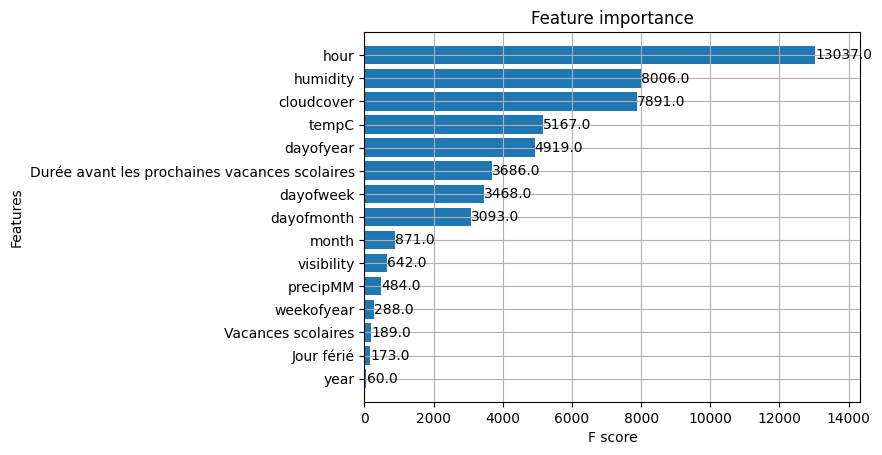

In [9]:
xgb.plot_importance(reg, height=0.8)

In [10]:
explainer = shap.Explainer(reg,X_train_sts)
shap_values = explainer.shap_values(X_train_sts)

100%|===================| 9544/9548 [06:29<00:00]        

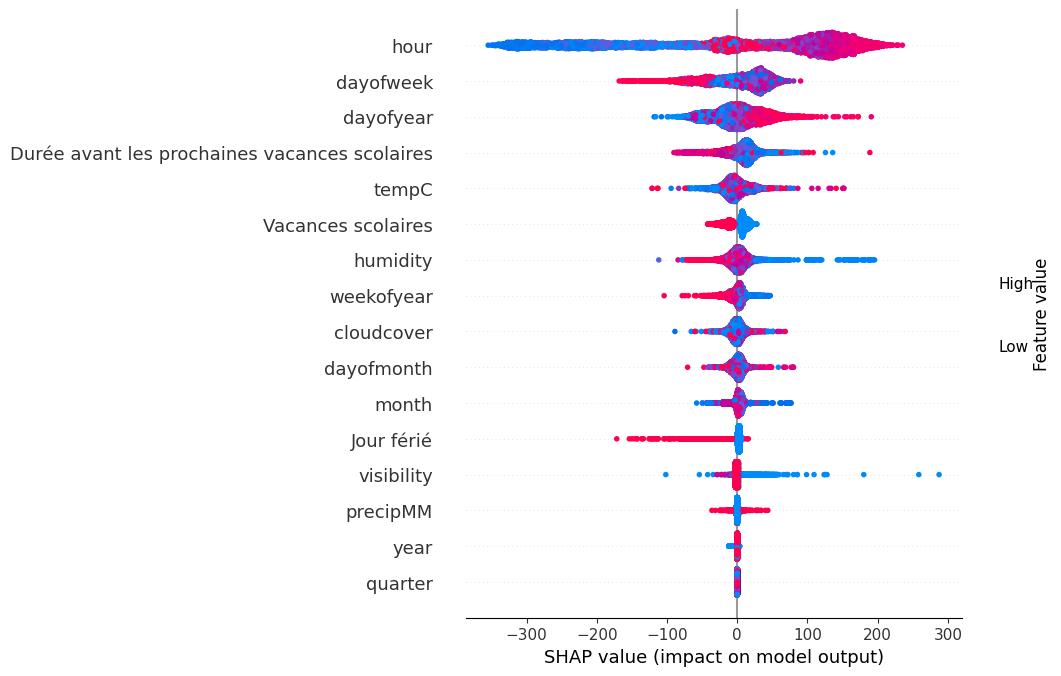

In [26]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_train_sts,feature_names = X_train_sts.columns,show=False)
plt.savefig('figs/shap_values_summary_plot.pdf',bbox_inches = 'tight',transparent=True)

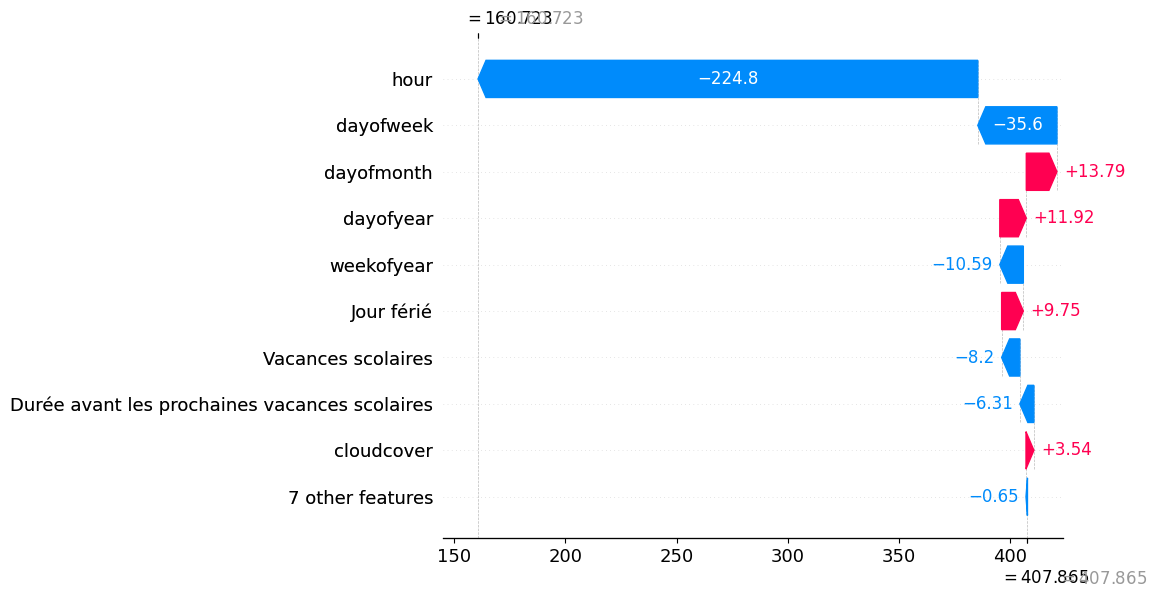

<Figure size 640x480 with 0 Axes>

In [25]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0],feature_names=X_train_sts.columns,max_display=10)
plt.savefig('figs/shap_values_waterfall_plot.png')

In [35]:
from sklearn.metrics import mean_squared_error
preds = reg.predict(X_test_conv)
rmse = mean_squared_error(preds,y_test_conv,squared=False)
print(f'rmse : {rmse}')

rmse : 3.134326891333589


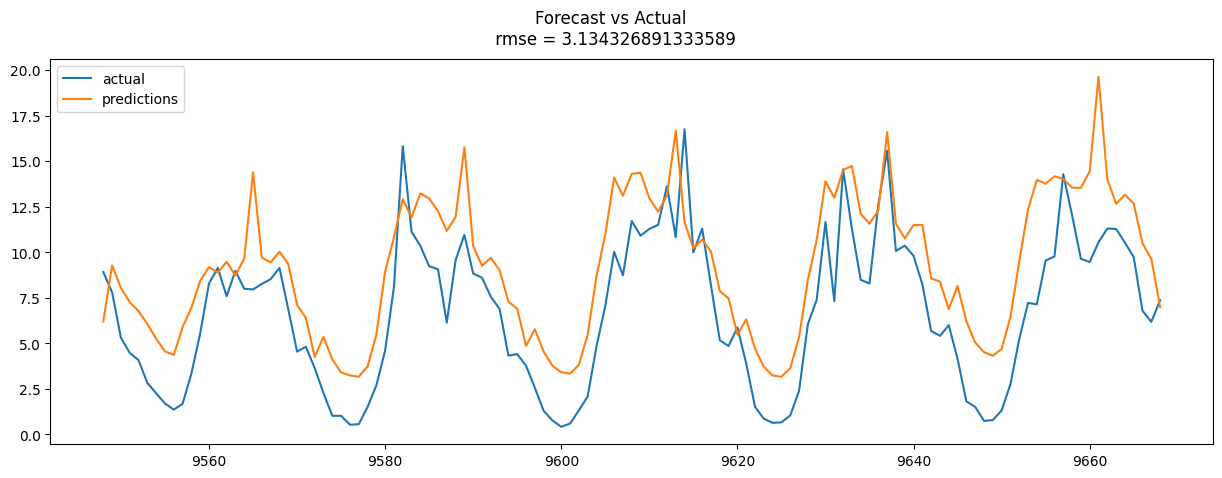

In [39]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)


y_all = pd.DataFrame({"actual":y_test_conv, "predictions":preds})

_ = y_all.plot(ax=ax)

plot = plt.suptitle('Forecast vs Actual \n rmse = {}'.format(rmse))